In [1]:
import json
import uproot
from XRootD import client
import xgboost as xgb
import os
import sys
sys.path.append("../../analysisTools/")
from skimmerTools import Skimmer
from analysisTools import Analyzer
from analysisTools import loadSchema
import plotTools as ptools
import coffea
import coffea.util as util
import numpy as np
import awkward as ak
import time
import h5py
import matplotlib.pyplot as plt
import pandas as pd
import mplhep
import glob
import hist
import matplotlib as mpl


### Run Skimmers on skimmed ntuples with preselections, produce h5 files for BDT input

In [95]:
outdir = "./h5/"
os.system(f"mkdir -p {outdir}")

0

In [96]:
def write_h5(data,fname):
    with h5py.File(fname,'w') as f:
        for k in data.keys():
            arr = data[k].value
            if type(arr) == np.ma.core.MaskedArray:
                arr = arr.data
            f.create_dataset(k,data=arr)

In [97]:
suffix = "_TrueVertexForSignal"

In [98]:
cut_config = "./preselections.py"

In [99]:
sig_sample_json_dir = './'
jsons = [f for f in os.listdir(sig_sample_json_dir) if ".json" in f]

signal_list = [ samp.split('.')[0] for samp in jsons if "skimmed_sig_v2_mA_3m1_2018_aEM" in samp ]
print(signal_list)

bkg_sample_json_dir = '../../configs/sample_configs/'
jsons = [f for f in os.listdir(bkg_sample_json_dir) if ".json" in f]

bkg_list = [ samp.split('.')[0] for samp in jsons if "skimmed_bkg" in samp ]
print(bkg_list)

['skimmed_sig_v2_mA_3m1_2018_aEM']
['skimmed_bkg_2018_DY', 'skimmed_bkg_2018_Diboson', 'skimmed_bkg_2018_QCD_TuneCP5_PSWeights', 'skimmed_bkg_2018_TTJetsDiLept', 'skimmed_bkg_2018_Top', 'skimmed_bkg_2018_Triboson', 'skimmed_bkg_2018_WJets', 'skimmed_bkg_2018_ZJets']


In [100]:
for samp in signal_list:
    print(f'Start analyzing: {samp}')
    
    test = Skimmer(f"{sig_sample_json_dir}/{samp}.json", cut_config)
    
    t1 = time.time()
    out = test.process(execr='futures')
    t2 = time.time()

    write_h5(out[0],f"{outdir}/{samp}{suffix}.h5")
    
    print('Completed in {:.2f} min\n'.format((t2-t1)/60))
    del out, test

Start analyzing: skimmed_sig_v2_mA_3m1_2018_aEM


Output()

Output()

Completed in 1.82 min



In [101]:
for samp in bkg_list:
    if 'TTJetsDiLept' in samp: # currently not available ntuples
        continue
    
    print(f'Start analyzing: {samp}')
    
    test = Skimmer(f"{bkg_sample_json_dir}/{samp}.json", cut_config)
    
    t1 = time.time()
    out = test.process(execr='futures')
    t2 = time.time()

    write_h5(out[0],f"{outdir}/{samp}{suffix}.h5")
    
    print('Completed in {:.2f} min\n'.format((t2-t1)/60))
    del out, test

Start analyzing: skimmed_bkg_2018_DY


Output()

Output()

Completed in 0.79 min

Start analyzing: skimmed_bkg_2018_Diboson


Output()

Output()

Completed in 0.59 min

Start analyzing: skimmed_bkg_2018_QCD_TuneCP5_PSWeights


Output()

Output()

Completed in 2.39 min

Start analyzing: skimmed_bkg_2018_Top


Output()

Output()

Completed in 3.67 min

Start analyzing: skimmed_bkg_2018_Triboson


Output()

Output()

Completed in 0.25 min

Start analyzing: skimmed_bkg_2018_WJets


Output()

Output()

Completed in 2.60 min

Start analyzing: skimmed_bkg_2018_ZJets


Output()

Output()

Completed in 2.43 min



## BDT -- high Vxy region: vxy > 0.5

In [2]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import xgboost as xgb
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score

In [3]:
h5_dir = "./h5/"
sig_suffix = "_TrueVertexForSignal"
bkg_suffix = "_TrueVertexForSignal"

sig_files = [f for f in os.listdir(h5_dir) if sig_suffix in f and 'sig' in f]
bkg_files = [f for f in os.listdir(h5_dir) if bkg_suffix in f and 'bkg' in f]

# vtx variables
variables = ['sel_vtx_chi2','sel_vtx_METdPhi','sel_vtx_m','sel_vtx_dR','sel_vtx_minDxy','vxy_signif']

sig_data = []

sig_xsec_norm = []
sig_point = {'m1':[], 'delta':[], 'ctau':[]}

for sf in sig_files:
    with h5py.File(f'{h5_dir}/{sf}',"r") as fin:
        entries = len(fin['wgt'])

        '''
        match = fin["sel_vtx_match"][()]
        mask = match==2

        entries_genMatched = sum(mask)
        print(f'Signal events {entries} -> {entries_genMatched} after gen matching (raw counts)\n')
        '''

        # Vxy mask
        vxy_thres = 0.5
        vxy_val = fin["vxy"][()]
        vxy_mask = vxy_val > vxy_thres
        entries_vxy_mask = sum(vxy_mask)
        
        sig_data.append(np.concatenate([fin[v][()][vxy_mask].reshape(-1,1) for v in variables],axis=1))
        sig_xsec_norm.append(fin['wgt_norm'][()][vxy_mask])
        
        sig_point['m1'].append(fin['m1'][()][vxy_mask])
        sig_point['delta'].append(fin['delta'][()][vxy_mask])
        sig_point['ctau'].append(fin['ctau'][()][vxy_mask])

        print(f'Signal events {entries} -> {entries_vxy_mask} after vxy cut (raw counts)\n')

sig_data = np.concatenate(sig_data,axis=0)
sig_xsec_norm = np.concatenate(sig_xsec_norm,axis=0)
sig_point['m1'] = np.concatenate(sig_point['m1'], axis=0)
sig_point['delta'] = np.concatenate(sig_point['delta'], axis=0)
sig_point['ctau'] = np.concatenate(sig_point['ctau'], axis=0)

nBkg = 0
bkg_data = []

bkg_xsec_norm = []

for bf in bkg_files:
    with h5py.File(f'{h5_dir}/{bf}',"r") as fin:
        process = bf.split('_')[3]
        entries = len(fin['wgt'])
        #print(f'{process}: {entries}')
        #nBkg += len(fin['wgt'])

        vxy_val = fin["vxy"][()]
        vxy_mask = vxy_val > vxy_thres
        entries_vxy_mask = sum(vxy_mask)

        print(f'{process}: {entries}, after vxy cut {entries_vxy_mask}')
        nBkg += len(fin['wgt'][vxy_mask])
        
        bkg_data.append(np.concatenate([fin[v][()][vxy_mask].reshape(-1,1) for v in variables],axis=1))
        bkg_xsec_norm.append(fin['wgt_norm'][()][vxy_mask])

bkg_xsec_norm = np.concatenate(bkg_xsec_norm,axis=0)


print(f'\nNumber of total background events (raw counts): {nBkg}')

bkg_data = np.concatenate(bkg_data,axis=0)

Signal events 12409 -> 6564 after vxy cut (raw counts)

DY: 9, after vxy cut 2
Diboson: 767, after vxy cut 419
QCD: 3, after vxy cut 1
Top: 2006, after vxy cut 972
Triboson: 92, after vxy cut 50
WJets: 29090, after vxy cut 16594
ZJets: 44480, after vxy cut 26108

Number of total background events (raw counts): 44146


In [4]:
print('Signal input statistics (unweighted)')

sig_subprocess = {}

for delta in [0.1, 0.2]:
    for m1 in [5.,10.,20.,30.,40.,50.]:
        for ctau in [1., 10., 100.]:
            idx = ((sig_point['m1'] == m1) & (sig_point['delta'] == delta))&(sig_point['ctau'] == ctau)
            point = f'm1_{m1}_delta_{delta}_ctau_{ctau}'
            sig_subprocess[point] = idx
            print(f'{point}: {np.sum(idx)}')

nSamp = 0
for samp, count in sig_subprocess.items():
    if np.sum(count) != 0:
        nSamp += 1
    else:
        print(f'{samp} has zero counts')

print(f'Number of signal subprocesses with non-zero count: {nSamp}')

Signal input statistics (unweighted)
m1_5.0_delta_0.1_ctau_1.0: 146
m1_5.0_delta_0.1_ctau_10.0: 103
m1_5.0_delta_0.1_ctau_100.0: 49
m1_10.0_delta_0.1_ctau_1.0: 235
m1_10.0_delta_0.1_ctau_10.0: 231
m1_10.0_delta_0.1_ctau_100.0: 88
m1_20.0_delta_0.1_ctau_1.0: 213
m1_20.0_delta_0.1_ctau_10.0: 186
m1_20.0_delta_0.1_ctau_100.0: 82
m1_30.0_delta_0.1_ctau_1.0: 159
m1_30.0_delta_0.1_ctau_10.0: 399
m1_30.0_delta_0.1_ctau_100.0: 182
m1_40.0_delta_0.1_ctau_1.0: 149
m1_40.0_delta_0.1_ctau_10.0: 374
m1_40.0_delta_0.1_ctau_100.0: 267
m1_50.0_delta_0.1_ctau_1.0: 156
m1_50.0_delta_0.1_ctau_10.0: 469
m1_50.0_delta_0.1_ctau_100.0: 274
m1_5.0_delta_0.2_ctau_1.0: 154
m1_5.0_delta_0.2_ctau_10.0: 79
m1_5.0_delta_0.2_ctau_100.0: 14
m1_10.0_delta_0.2_ctau_1.0: 219
m1_10.0_delta_0.2_ctau_10.0: 195
m1_10.0_delta_0.2_ctau_100.0: 50
m1_20.0_delta_0.2_ctau_1.0: 166
m1_20.0_delta_0.2_ctau_10.0: 307
m1_20.0_delta_0.2_ctau_100.0: 82
m1_30.0_delta_0.2_ctau_1.0: 153
m1_30.0_delta_0.2_ctau_10.0: 307
m1_30.0_delta_0.2_ct

## Reweight Backgrounds

### Background raw counts

In [5]:
bkg_raw = {}
nBkg = 0

for bf in bkg_files:
    with h5py.File(f'{h5_dir}/{bf}',"r") as fin:
        process = bf.split('_')[3]
        #entries = len(fin['wgt'])

        vxy_val = fin["vxy"][()]
        vxy_mask = vxy_val > vxy_thres

        entries = len(fin['wgt'][vxy_mask])
        
        print(f'{process}: {entries}')
        nBkg += len(fin['wgt'][vxy_mask])

        bkg_raw[process] = entries

DY: 2
Diboson: 419
QCD: 1
Top: 972
Triboson: 50
WJets: 16594
ZJets: 26108


### Cutflow counts (xsec weighted)

In [6]:
bkg_cts = {}
total_bkg_cts = 0

for bf in bkg_files:
    with h5py.File(f'{h5_dir}/{bf}',"r") as fin:
        process = bf.split('_')[3]

        vxy_val = fin["vxy"][()]
        vxy_mask = vxy_val > vxy_thres
        
        entries = sum(fin['wgt_norm'][()][vxy_mask])
        print(f'{process}: {entries}')

        total_bkg_cts += entries
        
        bkg_cts[process] = entries

print(f'Total background counts (xsec weighted): {total_bkg_cts}')

DY: 48.18195343017578
Diboson: 103.12341925501823
QCD: 7.842954158782959
Top: 139.54490206763148
Triboson: 0.9282614402472973
WJets: 6454.206764555012
ZJets: 3694.4399685978424
Total background counts (xsec weighted): 10448.26822350471


### Reweighing factor = `wgt_norm` / `total_bkg_cts` * `nBkg`

Reweigh the background samples, such that after reweighting the total number of backgrounds (BDT sample size) are unchanged but the relative contributions of each sub-process within the BDT sample are physically correct.

In [7]:
nBkg

44146

In [8]:
sf = {}
xsec_norm = {}

for bf in bkg_files:
    with h5py.File(f'{h5_dir}/{bf}',"r") as fin:
        process = bf.split('_')[3]

        vxy_val = fin["vxy"][()]
        vxy_mask = vxy_val > vxy_thres
        
        entries = fin['wgt_norm'][()][vxy_mask] / total_bkg_cts * nBkg
        print(f'{process}: {entries}')

        sf[process] = entries
        xsec_norm[process] = fin['wgt_norm'][()][vxy_mask]

DY: [101.78914 101.78914]
Diboson: [0.9140915 0.9140915 0.9140915 0.9140915 0.9140915 0.9140915 0.9140915
 0.9140915 0.9140915 0.9140915 0.9140915 0.9140915 0.9140915 0.9140915
 0.9140915 0.9140915 0.9140915 0.9140915 0.9140915 0.9140915 0.9140915
 0.9140915 0.9140915 0.9140915 0.9140915 0.9140915 0.9140915 0.9140915
 0.9140915 0.9140915 0.9140915 0.9140915 0.9140915 0.9140915 0.9140915
 0.9140915 0.9140915 0.9140915 0.9140915 0.9140915 0.9140915 0.9140915
 0.9140915 0.9140915 0.9140915 0.9140915 0.9140915 0.9140915 0.9140915
 0.9140915 0.9140915 0.9140915 0.9140915 0.9140915 0.9140915 0.9140915
 0.9140915 0.9140915 0.9140915 0.9140915 0.9140915 0.9140915 0.9140915
 0.9140915 0.9140915 0.9140915 0.9140915 0.9140915 0.9140915 0.9140915
 0.9140915 0.9140915 0.9140915 0.9140915 0.9140915 0.9140915 0.9140915
 0.9140915 0.9140915 0.9140915 0.9140915 0.9140915 0.9140915 0.9140915
 0.9140915 0.9140915 0.9140915 0.9140915 0.9140915 0.9140915 0.9140915
 0.9140915 0.9140915 0.9140915 0.9140915 0

**With the weight applied, the total bkg events are the same as raw counts, but the contribution of the relative xsec is considered now.**

In [9]:
total_weighted = 0

for process in sf.keys():
    print(f'{process}: {sum(sf[process])}')
    total_weighted += sum(sf[process])

print(total_weighted)

DY: 203.57827758789062
Diboson: 435.71682637929916
QCD: 33.138031005859375
Top: 589.604786157608
Triboson: 3.9220881909132004
WJets: 27270.30116740265
ZJets: 15609.739311859012
44146.00048858323


In [10]:
nBkg

44146

In [11]:
# SF
bkg_sf = []
bkg_xsec_norm = []

for process in sf.keys():
    bkg_sf += list(sf[process])
    bkg_xsec_norm += list(xsec_norm[process])

print(len(bkg_sf))

44146


In [12]:
set(bkg_xsec_norm)

{-0.05953975,
 -0.045444746,
 -0.016287146,
 -0.012563892,
 0.00075470324,
 0.0012511426,
 0.0042385785,
 0.004238579,
 0.01063748,
 0.012563892,
 0.016287146,
 0.024323996,
 0.028713468,
 0.030013198,
 0.037092578,
 0.038779505,
 0.039841752,
 0.043379143,
 0.045444746,
 0.05953975,
 0.08565486,
 0.18472649,
 0.19808361,
 0.2163429,
 0.2441929,
 0.2524531,
 0.29107392,
 0.34455764,
 0.3913622,
 0.55844516,
 1.1887455,
 2.7895231,
 7.842954,
 24.090977}

In [13]:
len(bkg_sf)

44146

## Reweight Signal

For signal, we also apply the reweighting factors.
1) First, since our signal samples are smaller than background samples, get the overall scale factor for signal samples to match the total number of background samples. Reweigh against background.
2) Then, reweigh across signal samples. We will make all signal subprocesses "equally shown" to the BDT. Currently the inputs are biased, i.e. to have more 10% splitting, 1mm ctau, etc. We will flatten these out.

In [14]:
bkg_to_sig = len(bkg_xsec_norm)/len(sig_xsec_norm)

print(f'Signal sample size (all subprocesses summed): {len(sig_xsec_norm)}')
print(f'Background sample size (all subprocesses summed): {len(bkg_xsec_norm)}')
print(f'{bkg_to_sig} more background than signal samples')

Signal sample size (all subprocesses summed): 6564
Background sample size (all subprocesses summed): 44146
6.725472273004265 more background than signal samples


In [15]:
print(f'There are {nSamp} subprocesses in signal, i.e. per m1/delta/ctau points.')
print(f'\nIdeally, sig and bkg sample size for BDT input should be the same.')
print(f'\nFor background, we care about each background process contribution to the total, i.e. QCD having higher xsec than Diboson.')
print(f'This should be taken into account, so we got the SF for background input that will correct for this relative xsec contribution.')
print(f'\nFor signal, we want BDT to equally "see" each subprocess. For example, delta=0.2 splitting has lower xsec than delta=0.1.')
print(f'But we want the BDT to "equally" see them. Therefore, we reweigh signal such that each subprocess relative contribution is the same.')
print(f'For signal, we also get the overall SF against bkg, because right now we have 10 times less signal input than background.')

There are 36 subprocesses in signal, i.e. per m1/delta/ctau points.

Ideally, sig and bkg sample size for BDT input should be the same.

For background, we care about each background process contribution to the total, i.e. QCD having higher xsec than Diboson.
This should be taken into account, so we got the SF for background input that will correct for this relative xsec contribution.

For signal, we want BDT to equally "see" each subprocess. For example, delta=0.2 splitting has lower xsec than delta=0.1.
But we want the BDT to "equally" see them. Therefore, we reweigh signal such that each subprocess relative contribution is the same.
For signal, we also get the overall SF against bkg, because right now we have 10 times less signal input than background.


In [16]:
print(f'This means, for each one of {nSamp} signal subprocesses, there should be [n(background sample size)/n(number of signal subprocess)] = {len(bkg_xsec_norm)/nSamp}')

This means, for each one of 36 signal subprocesses, there should be [n(background sample size)/n(number of signal subprocess)] = 1226.2777777777778


In [17]:
print(f'We will get the SF for each signal subprocess such that their weighted count corresponds to {len(bkg_xsec_norm)/nSamp}')

We will get the SF for each signal subprocess such that their weighted count corresponds to 1226.2777777777778


In [18]:
sig_sf = np.zeros(len(sig_xsec_norm)) # initialize

nSubprocessWeighted = len(bkg_xsec_norm)/nSamp
#nSubprocessWeighted = nSamp

for samp, idx in sig_subprocess.items():
    samp_idx = np.nonzero(idx)[0]
    nSubprocess = np.sum(idx) # unweighted
    if nSubprocess == 0:
        continue
    sf = nSubprocessWeighted/nSubprocess

    sig_sf[samp_idx] = sf

print(sig_sf)

[87.59126984 87.59126984 87.59126984 ...  5.21820331  5.21820331
  5.21820331]


In [19]:
type(sig_sf)

numpy.ndarray

### Train

In [20]:
bkg_sf_arr = np.array(bkg_sf)
sig_sf_arr = sig_sf

In [21]:
rng = np.random.default_rng(seed=438290)
random_state = rng.integers(0,100000,1)[0]

# 8-2 split of train/test set; shuffle the array of SFs accordingly
sig_train, sig_test = train_test_split(sig_data,train_size=0.8,random_state=random_state)
sig_train_sf, sig_test_sf = train_test_split(sig_sf_arr, train_size=0.8, random_state=random_state)
sig_train_xsec_norm, sig_test_xsec_norm = train_test_split(sig_xsec_norm, train_size=0.8, random_state=random_state)
sig_train_m1, sig_test_m1 = train_test_split(sig_point['m1'], train_size=0.8, random_state=random_state)
sig_train_delta, sig_test_delta = train_test_split(sig_point['delta'], train_size=0.8, random_state=random_state)
sig_train_ctau, sig_test_ctau = train_test_split(sig_point['ctau'], train_size=0.8, random_state=random_state)

bkg_train, bkg_test = train_test_split(bkg_data,train_size=0.8,random_state=random_state)
bkg_train_sf, bkg_test_sf = train_test_split(bkg_sf_arr, train_size=0.8, random_state=random_state)
bkg_train_xsec_norm, bkg_test_xsec_norm = train_test_split(bkg_xsec_norm, train_size=0.8, random_state=random_state)

bkg_train_m1, bkg_test_m1 = train_test_split(np.zeros(bkg_sf_arr.shape[0]), train_size=0.8, random_state=random_state)
bkg_train_delta, bkg_test_delta = train_test_split(np.zeros(bkg_sf_arr.shape[0]), train_size=0.8, random_state=random_state)
bkg_train_ctau, bkg_test_ctau = train_test_split(np.zeros(bkg_sf_arr.shape[0]), train_size=0.8, random_state=random_state)

train = np.concatenate((sig_train,bkg_train),axis=0)
train_sf = np.concatenate((sig_train_sf,bkg_train_sf),axis=0)
train_sf = abs(train_sf)  # training sf cannot have negative values, genWgts have negative values, take abs for now, which is not correct :( 

y_train = np.concatenate((np.ones(len(sig_train)),np.zeros(len(bkg_train))),axis=0)

perm = rng.permutation(len(train))
train = train[perm]
y_train = y_train[perm]
dtrain = xgb.DMatrix(train,label=y_train,feature_names=variables)

test = np.concatenate((sig_test,bkg_test),axis=0)
test_sf = np.concatenate((sig_test_sf,bkg_test_sf),axis=0) # not used

test_xsec_norm = np.concatenate((sig_test_xsec_norm, bkg_test_xsec_norm), axis=0)

test_m1 = np.concatenate((sig_test_m1,bkg_test_m1),axis=0)
test_delta = np.concatenate((sig_test_delta,bkg_test_delta),axis=0)
test_ctau = np.concatenate((sig_test_ctau,bkg_test_ctau),axis=0)

y_test = np.concatenate((np.ones(len(sig_test)),np.zeros(len(bkg_test))),axis=0)

perm = rng.permutation(len(test))
test = test[perm]
y_test = y_test[perm]
test_xsec_norm = test_xsec_norm[perm]
test_m1 = test_m1[perm]
test_delta = test_delta[perm]
test_ctau = test_ctau[perm]

dtest = xgb.DMatrix(test,label=y_test,feature_names=variables)

In [134]:
test_ctau[np.where(y_test == 1)] # signal

array([ 1.,  1., 10., ..., 10., 10., 10.])

In [135]:
test_ctau[np.where(y_test == 0)] # bkg; should all be zeros by construction, printing out to check if this is the case (not messed up by random_state)

array([0., 0., 0., ..., 0., 0., 0.])

In [136]:
bst = xgb.XGBRegressor(n_estimators=100, max_depth=10, learning_rate=0.05, objective='binary:logistic')

# fit model
bst.fit(train, y_train, sample_weight=train_sf)
#bst.fit(train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             objective='binary:logistic', predictor=None, ...)

In [137]:
# make predictions
preds = bst.predict(test)

In [138]:
os.system('mkdir -p plots')

0

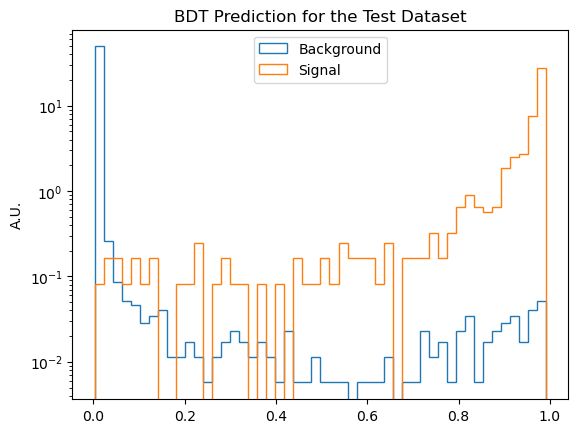

In [139]:
bins = 50

h,bins,_ = plt.hist(preds[y_test==0],bins=bins,density=True,histtype='step', label='Background')
h,bins,_ = plt.hist(preds[y_test==1],bins=bins,density=True,histtype='step', label='Signal')

plt.legend()
plt.title('BDT Prediction for the Test Dataset')

plt.ylabel('A.U.')
plt.savefig('plots/BDT_highLxy_thres_0p5_score.png')
plt.yscale('log')

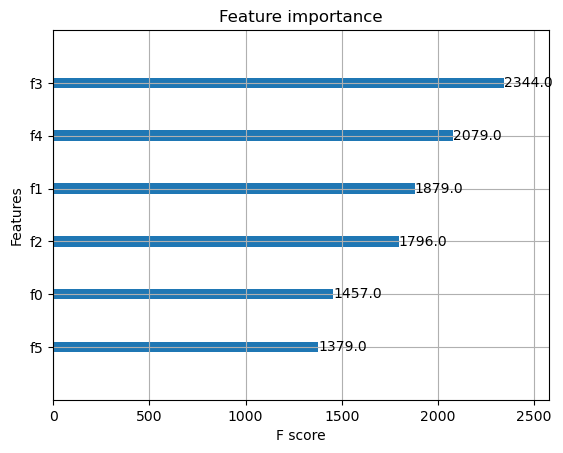

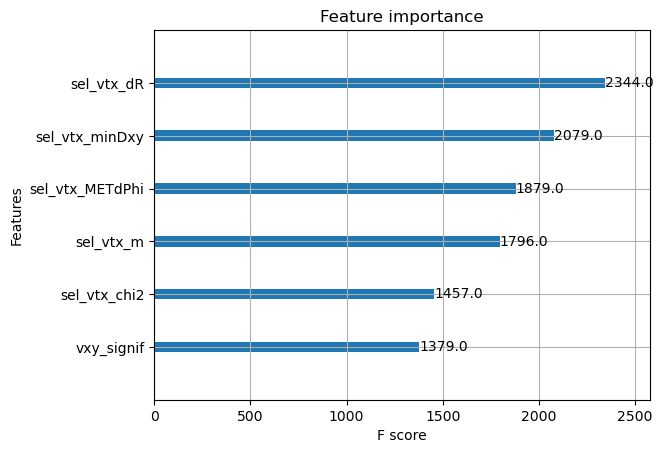

In [140]:
# Label the feature importance plot: replace, i.e. f1 with the variable name lead_jet_pt
label_dict = {}

for idx, var in enumerate(variables):
    label_dict['f{}'.format(idx)] = var
#print(label_dict)

# Plot importance

xgb.plot_importance(bst)

ticks = [ item.get_text() for item in plt.gca().get_yticklabels() ]
#print(ticks)
relabel = [ label_dict[tick] for tick in ticks ]
#print(relabel)

# Plot importance with axis with variable names
xgb.plot_importance(bst).set_yticklabels(relabel)
plt.savefig('plots/BDT_highLxy_thres_0p5_importance_bst.png', bbox_inches = "tight")

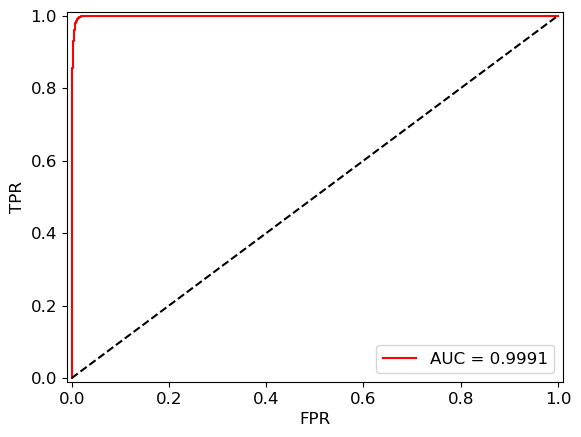

In [141]:
# ROC
from sklearn.metrics import roc_auc_score, classification_report, accuracy_score, roc_curve, confusion_matrix, average_precision_score, precision_recall_curve

# make predictions

fpr, tpr, thresholds = roc_curve(y_test, preds)
auc = roc_auc_score(y_test, preds)
precision, recall, thresholds2 = precision_recall_curve(y_test, preds)

plt.plot(fpr, tpr, color = "red", label = F"AUC = {auc:.4f}")

plt.plot([0,1], [0,1] , color = "black", ls = "--")
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('FPR' , fontsize=12)
plt.ylabel('TPR' , fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend( prop={'size':12} , loc = 4)
plt.savefig('plots/BDT_highLxy_thres_0p5_roc_curve.png')

### Save and load

In [143]:
os.system('mkdir -p models')

0

In [144]:
bst.save_model('models/BDT_highLxy_thres_0p5.json')

In [22]:
trained_model = xgb.XGBRegressor()
trained_model.load_model("models/BDT_highLxy_thres_0p5.json")

In [23]:
prediction = trained_model.predict(test)

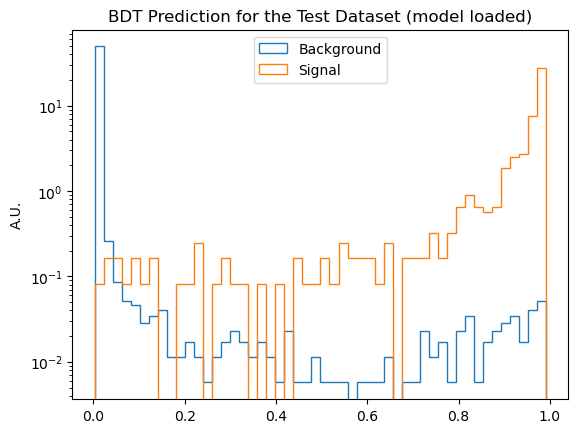

In [24]:
bins = 50

h_bkg,bins,_ = plt.hist(prediction[y_test==0],bins=bins,density=True,histtype='step', label='Background')
h_sig,bins,_ = plt.hist(prediction[y_test==1],bins=bins,density=True,histtype='step', label='Signal')

plt.legend()
plt.title('BDT Prediction for the Test Dataset (model loaded)')

plt.ylabel('A.U.')
plt.yscale('log')

In [25]:
h_sig = h_sig[::-1]
h_sig

array([27.75320286,  7.50969019,  2.69369322,  2.53043908,  1.87742255,
        0.65301851,  0.57138947,  0.65301654,  0.89789774,  0.65301654,
        0.32650827,  0.16325413,  0.32650827,  0.16325413,  0.16325413,
        0.16325413,  0.        ,  0.2448812 ,  0.08162707,  0.16325413,
        0.16325413,  0.16325413,  0.2448812 ,  0.08162707,  0.16325413,
        0.08162719,  0.08162707,  0.16325413,  0.        ,  0.08162707,
        0.        ,  0.08162707,  0.        ,  0.08162707,  0.08162707,
        0.16325413,  0.08162719,  0.        ,  0.2448812 ,  0.08162707,
        0.08162713,  0.        ,  0.        ,  0.16325426,  0.08162707,
        0.1632542 ,  0.0816271 ,  0.16325417,  0.16325418,  0.08162709])

In [26]:
h_bkg = h_bkg[::-1]
h_bkg

array([5.15831297e-02, 4.01202120e-02, 1.71943766e-02, 3.43887531e-02,
       2.86572943e-02, 2.29259046e-02, 1.71943766e-02, 5.73145885e-03,
       3.43887531e-02, 2.29258354e-02, 5.73145885e-03, 1.71943766e-02,
       1.14629177e-02, 2.29258354e-02, 5.73145885e-03, 5.73145885e-03,
       0.00000000e+00, 1.14629177e-02, 5.73145885e-03, 5.73145885e-03,
       5.73145885e-03, 0.00000000e+00, 5.73145885e-03, 5.73145885e-03,
       5.73145885e-03, 1.14629350e-02, 5.73145885e-03, 5.73145885e-03,
       2.29258354e-02, 5.73145885e-03, 1.14629350e-02, 1.71943766e-02,
       1.14629177e-02, 1.71943766e-02, 2.29258354e-02, 1.71943766e-02,
       1.14629350e-02, 5.73145885e-03, 1.14629177e-02, 1.71943766e-02,
       1.14629264e-02, 1.14629177e-02, 4.01202120e-02, 3.43887791e-02,
       2.86572943e-02, 4.58516881e-02, 5.15831491e-02, 8.59718990e-02,
       2.63647182e-01, 4.94510410e+01])

In [27]:
# S/B scan on the score (xsec unweighted)
h_sig_sum = []
h_bkg_sum = []

for idx, entry in enumerate(h_sig):
    integral = 0
    for j in range(idx):
        integral += h_sig[j]
    h_sig_sum.append(integral)

for idx, entry in enumerate(h_bkg):
    integral = 0
    for j in range(idx):
        integral += h_bkg[j]
    h_bkg_sum.append(integral)

np.array(h_sig_sum)/np.array(h_bkg_sum)

/tmp/ipykernel_6069/326739833.py:17: RuntimeWarning: invalid value encountered in divide
  np.array(h_sig_sum)/np.array(h_bkg_sum)


array([         nan, 538.02867384, 384.53225806, 348.55263158,
       282.56      , 246.38548387, 220.74993177, 205.54571384,
       203.13491908, 178.99519333, 166.45258629, 164.21820226,
       155.29184402, 150.59525348, 140.70047721, 138.79850122,
       136.95992442, 136.95992442, 133.23098898, 131.34227421,
       129.73511196, 128.17740085, 128.61561417, 127.31425368,
       125.62660745, 124.19803804, 120.85297457, 119.35141096,
       118.08936205, 111.87413371, 110.60618333, 107.80602321,
       104.03558338, 101.55854621,  98.22022848,  94.05936141,
        91.36048732,  89.60549507,  88.68172728,  87.32175133,
        84.89309185,  83.39747327,  81.82393638,  76.75519797,
        73.12454634,  70.29083086,  66.24656681,  62.1190686 ,
        56.32867041,  43.6423582 ])

[Text(0, 0, 'vxy_signif'),
 Text(0, 1, 'sel_vtx_chi2'),
 Text(0, 2, 'sel_vtx_m'),
 Text(0, 3, 'sel_vtx_METdPhi'),
 Text(0, 4, 'sel_vtx_minDxy'),
 Text(0, 5, 'sel_vtx_dR')]

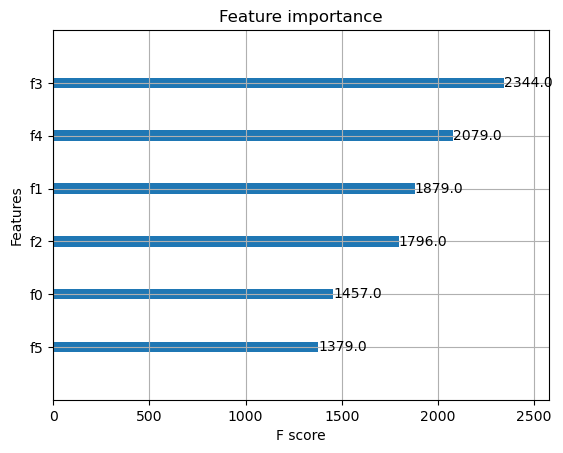

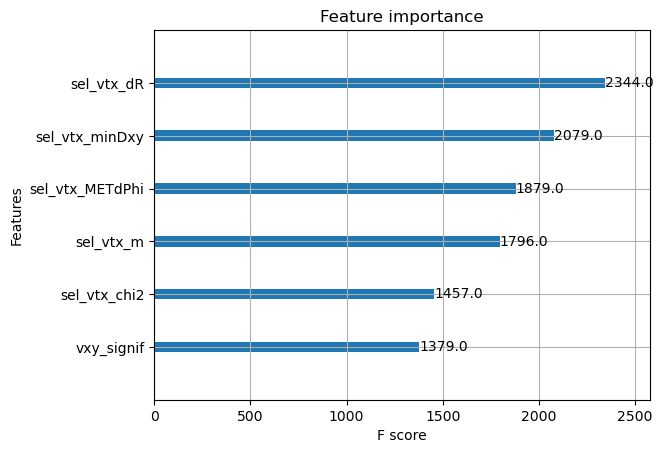

In [28]:
# Label the feature importance plot: replace, i.e. f1 with the variable name lead_jet_pt
label_dict = {}

for idx, var in enumerate(variables):
    label_dict['f{}'.format(idx)] = var
#print(label_dict)

# Plot importance

xgb.plot_importance(trained_model)

ticks = [ item.get_text() for item in plt.gca().get_yticklabels() ]
#print(ticks)
relabel = [ label_dict[tick] for tick in ticks ]
#print(relabel)

# Plot importance with axis with variable names
xgb.plot_importance(trained_model).set_yticklabels(relabel)
#plt.savefig('plots/importance_bst_weighted.png', bbox_inches = "tight")

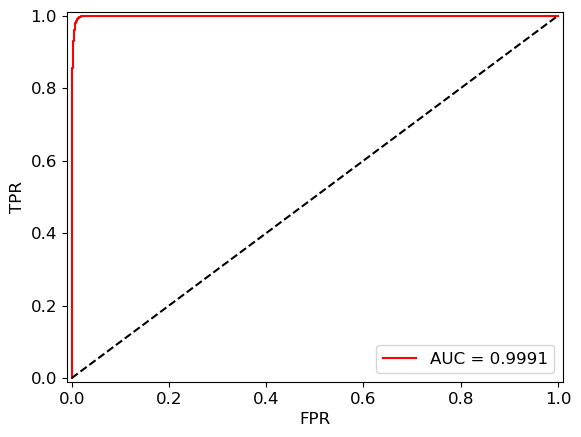

In [29]:
# ROC
from sklearn.metrics import roc_auc_score, classification_report, accuracy_score, roc_curve, confusion_matrix, average_precision_score, precision_recall_curve

# make predictions

fpr, tpr, thresholds = roc_curve(y_test, prediction)
auc = roc_auc_score(y_test, prediction)
precision, recall, thresholds2 = precision_recall_curve(y_test, prediction)

plt.plot(fpr, tpr, color = "red", label = F"AUC = {auc:.4f}")

plt.plot([0,1], [0,1] , color = "black", ls = "--")
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('FPR' , fontsize=12)
plt.ylabel('TPR' , fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend( prop={'size':12} , loc = 4)
#plt.savefig('plots/roc_curve_weighted_training.png')

### WP

In [30]:
idx_valid = thresholds < 1

tpr = tpr[idx_valid]
thresholds = thresholds[idx_valid]

In [31]:
tpr_WP = {'tight': 0.7, 'medium': 0.85, 'loose': 0.9}
thres_WP = {'tight': 0, 'medium': 0, 'loose': 0}

In [34]:
epsilon = 0.007

for wp in tpr_WP.keys():    
    idx = np.where((tpr > tpr_WP[wp] - epsilon) & (tpr < tpr_WP[wp] + epsilon))
    
    thres_WP[wp] = thresholds[idx].mean()

    print(f'{wp} threshold: {thres_WP[wp]}')

tight threshold: 0.9829236268997192
medium threshold: 0.9523851871490479
loose threshold: 0.9205628633499146


### TPR

In [156]:
# BDT scores for the signal
nPass_sig = {'tight': 0, 'medium': 0, 'loose': 0}
nPass_bkg = {'tight': 0, 'medium': 0, 'loose': 0}

for wp in nPass_sig.keys():
    nPass_sig[wp] = np.sum(preds[np.where(y_test==1)] > thres_WP[wp])
    nPass_bkg[wp] = np.sum(preds[np.where(y_test==0)] > thres_WP[wp])
    
    print(f'\n{wp} pass')
    print(f'TPR: {nPass_sig[wp]} / {len(preds[np.where(y_test==1)])} = {nPass_sig[wp]/len(preds[np.where(y_test==1)])}')
    print(f'FPR: {nPass_bkg[wp]} / {len(preds[np.where(y_test==0)])} = {nPass_bkg[wp]/len(preds[np.where(y_test==0)])}')


tight pass
TPR: 917 / 1313 = 0.6984006092916984
FPR: 4 / 8830 = 0.00045300113250283127

medium pass
TPR: 1048 / 1313 = 0.7981721249047982
FPR: 10 / 8830 = 0.0011325028312570782

loose pass
TPR: 1169 / 1313 = 0.8903274942878904
FPR: 23 / 8830 = 0.0026047565118912795


In [157]:
# for a given point
m1 = 30.
delta = 0.1
ctau = 1.

nPass_sig_sigpoint = {'tight': 0, 'medium': 0, 'loose': 0}
nPass_bkg_sigpoint = {'tight': 0, 'medium': 0, 'loose': 0}

for wp in nPass_sig.keys():
    sig_idx = np.where(((y_test==1) & (test_m1 == m1)) & ((test_delta == delta) & (test_ctau == ctau)))
    bkg_idx = np.where(y_test==0)
    
    nPass_sig_sigpoint[wp] = np.sum(preds[sig_idx] > thres_WP[wp])
    nPass_bkg_sigpoint[wp] = np.sum(preds[bkg_idx] > thres_WP[wp])
    
    print(f'\n{wp} pass')
    print(f'TPR: {nPass_sig_sigpoint[wp]} / {len(preds[sig_idx])} = {nPass_sig_sigpoint[wp]/len(preds[sig_idx])}')
    print(f'FPR: {nPass_bkg_sigpoint[wp]} / {len(preds[bkg_idx])} = {nPass_bkg_sigpoint[wp]/len(preds[bkg_idx])}')


tight pass
TPR: 23 / 33 = 0.696969696969697
FPR: 4 / 8830 = 0.00045300113250283127

medium pass
TPR: 29 / 33 = 0.8787878787878788
FPR: 10 / 8830 = 0.0011325028312570782

loose pass
TPR: 30 / 33 = 0.9090909090909091
FPR: 23 / 8830 = 0.0026047565118912795


### TPR per signal point

In [178]:
tpr_raw = { '0.1': {'ct-1': {'tight':[], 'medium':[], 'loose':[]}, 'ct-10': {'tight':[], 'medium':[], 'loose':[]}, 'ct-100': {'tight':[], 'medium':[], 'loose':[]}}, \
            '0.2': {'ct-1': {'tight':[], 'medium':[], 'loose':[]}, 'ct-10': {'tight':[], 'medium':[], 'loose':[]}, 'ct-100': {'tight':[], 'medium':[], 'loose':[]}}
          }

for ctau in [1.,10.,100.]:
    for delta in [0.1, 0.2]:
        for m1 in [5., 10., 20., 30., 40., 50.]:
            nPass_sig_raw_sigpoint = {'tight': 0, 'medium': 0, 'loose': 0}
            nPass_bkg_raw_sigpoint = {'tight': 0, 'medium': 0, 'loose': 0}
            
            for wp in nPass_sig.keys():
                sig_idx = np.where(((y_test==1) & (test_m1 == m1)) & ((test_delta == delta) & (test_ctau == ctau)))
                bkg_idx = np.where(y_test==0)
                
                nPass_sig_raw_sigpoint[wp] = np.sum(preds[sig_idx] > thres_WP[wp])
                nPass_bkg_raw_sigpoint[wp] = np.sum(preds[bkg_idx] > thres_WP[wp])

                if len(sig_idx[0]) == 0:
                    tpr_raw[f'{delta}'][f'ct-{int(ctau)}'][wp].append(0)
                    continue
                
                print(f'm1 = {m1}, delta = {delta}, ct = {ctau}')
                print(f'TPR: {nPass_sig_raw_sigpoint[wp]} / {len(sig_idx[0])} = {nPass_sig_raw_sigpoint[wp]/len(sig_idx[0])}')

                tpr_raw[f'{delta}'][f'ct-{int(ctau)}'][wp].append(nPass_sig_raw_sigpoint[wp]/len(sig_idx[0]))

m1 = 5.0, delta = 0.1, ct = 1.0
TPR: 17 / 82 = 0.2073170731707317
m1 = 5.0, delta = 0.1, ct = 1.0
TPR: 32 / 82 = 0.3902439024390244
m1 = 5.0, delta = 0.1, ct = 1.0
TPR: 55 / 82 = 0.6707317073170732
m1 = 10.0, delta = 0.1, ct = 1.0
TPR: 52 / 116 = 0.4482758620689655
m1 = 10.0, delta = 0.1, ct = 1.0
TPR: 77 / 116 = 0.6637931034482759
m1 = 10.0, delta = 0.1, ct = 1.0
TPR: 94 / 116 = 0.8103448275862069
m1 = 20.0, delta = 0.1, ct = 1.0
TPR: 66 / 112 = 0.5892857142857143
m1 = 20.0, delta = 0.1, ct = 1.0
TPR: 85 / 112 = 0.7589285714285714
m1 = 20.0, delta = 0.1, ct = 1.0
TPR: 95 / 112 = 0.8482142857142857
m1 = 30.0, delta = 0.1, ct = 1.0
TPR: 60 / 85 = 0.7058823529411765
m1 = 30.0, delta = 0.1, ct = 1.0
TPR: 71 / 85 = 0.8352941176470589
m1 = 30.0, delta = 0.1, ct = 1.0
TPR: 78 / 85 = 0.9176470588235294
m1 = 40.0, delta = 0.1, ct = 1.0
TPR: 47 / 70 = 0.6714285714285714
m1 = 40.0, delta = 0.1, ct = 1.0
TPR: 52 / 70 = 0.7428571428571429
m1 = 40.0, delta = 0.1, ct = 1.0
TPR: 66 / 70 = 0.942857142

In [179]:
tpr_raw

{'0.1': {'ct-1': {'tight': [0.2073170731707317,
    0.4482758620689655,
    0.5892857142857143,
    0.7058823529411765,
    0.6714285714285714,
    0.7012987012987013],
   'medium': [0.3902439024390244,
    0.6637931034482759,
    0.7589285714285714,
    0.8352941176470589,
    0.7428571428571429,
    0.8051948051948052],
   'loose': [0.6707317073170732,
    0.8103448275862069,
    0.8482142857142857,
    0.9176470588235294,
    0.9428571428571428,
    0.8701298701298701]},
  'ct-10': {'tight': [0.4489795918367347,
    0.553030303030303,
    0.6804123711340206,
    0.839572192513369,
    0.8232044198895028,
    0.8270042194092827],
   'medium': [0.6326530612244898,
    0.7121212121212122,
    0.8556701030927835,
    0.893048128342246,
    0.8895027624309392,
    0.8607594936708861],
   'loose': [0.7755102040816326,
    0.8863636363636364,
    0.9175257731958762,
    0.9572192513368984,
    0.9668508287292817,
    0.9282700421940928]},
  'ct-100': {'tight': [0.30434782608695654,
    0.6

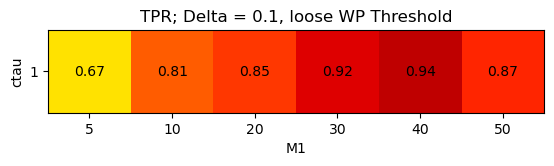

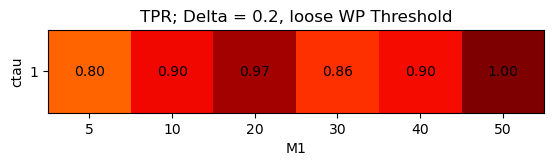

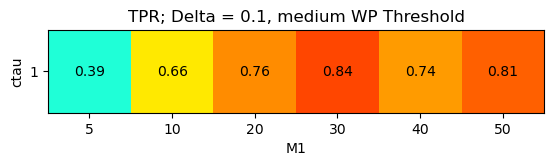

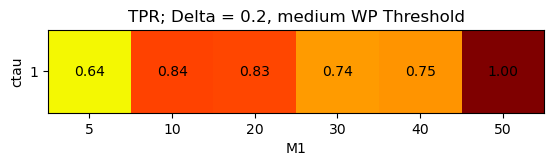

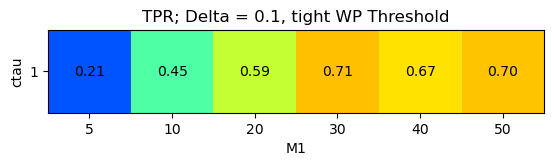

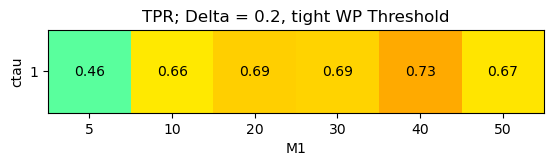

In [180]:
for wp in ['loose', 'medium', 'tight']:
    for delta in ['0.1', '0.2']:
        fig, ax = plt.subplots(1)
      
        arr = np.array([tpr_raw[delta]['ct-1'][wp]])
        
        ax.imshow(arr, interpolation ='none', cmap='jet', vmin=0, vmax=1)
        
        #plt.colorbar(im)
        
        for (j,i),label in np.ndenumerate(arr):
            label = '{:.2f}'.format(label)
            ax.text(i,j,label,ha='center',va='center')
        
        plt.title(f'TPR; Delta = {delta}, {wp} WP Threshold')
        plt.ylabel('ctau')
        plt.xlabel('M1')
        
        plt.xticks(range(0,6), [5, 10, 20, 30, 40, 50])
        plt.yticks(range(0,1), [1])
        plt.gca().invert_yaxis()
        
        plt.show()

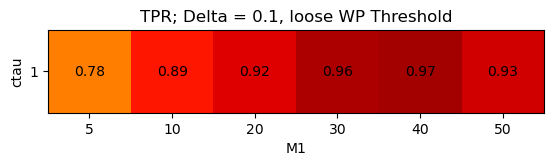

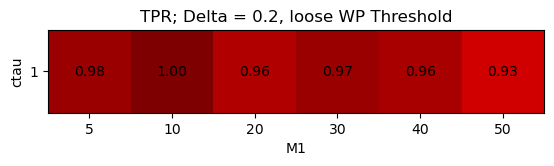

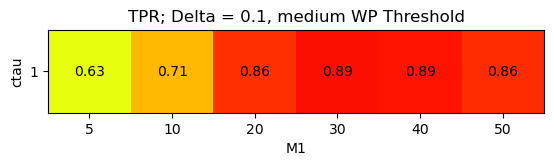

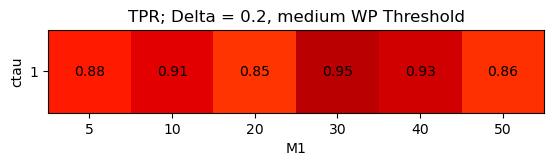

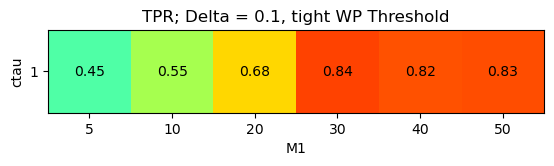

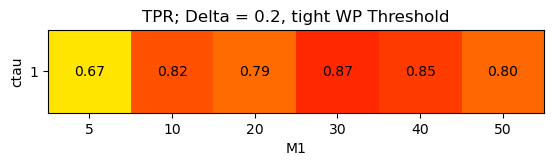

In [181]:
for wp in ['loose', 'medium', 'tight']:
    for delta in ['0.1', '0.2']:
        fig, ax = plt.subplots(1)
      
        arr = np.array([tpr_raw[delta]['ct-10'][wp]])
        
        ax.imshow(arr, interpolation ='none', cmap='jet', vmin=0, vmax=1)
        
        #plt.colorbar(im)
        
        for (j,i),label in np.ndenumerate(arr):
            label = '{:.2f}'.format(label)
            ax.text(i,j,label,ha='center',va='center')
        
        plt.title(f'TPR; Delta = {delta}, {wp} WP Threshold')
        plt.ylabel('ctau')
        plt.xlabel('M1')
        
        plt.xticks(range(0,6), [5, 10, 20, 30, 40, 50])
        plt.yticks(range(0,1), [1])
        plt.gca().invert_yaxis()
        
        plt.show()

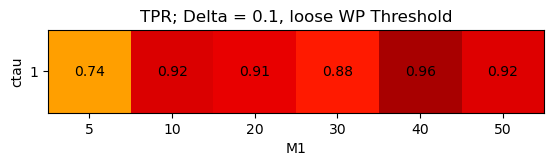

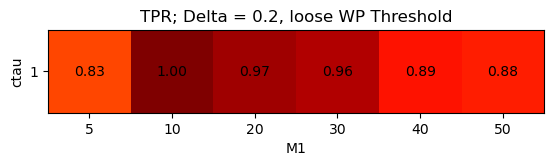

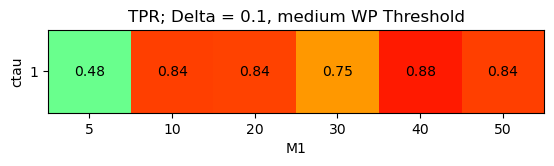

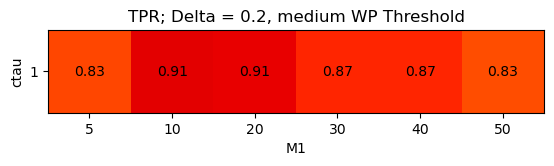

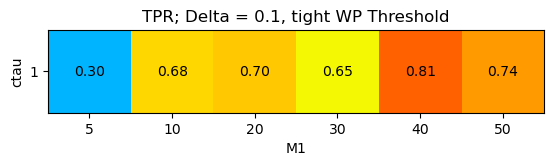

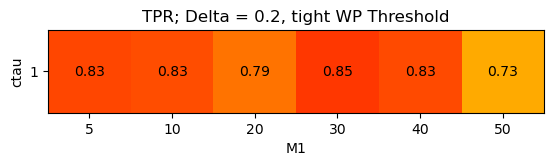

In [182]:
for wp in ['loose', 'medium', 'tight']:
    for delta in ['0.1', '0.2']:
        fig, ax = plt.subplots(1)
      
        arr = np.array([tpr_raw[delta]['ct-100'][wp]])
        
        ax.imshow(arr, interpolation ='none', cmap='jet', vmin=0, vmax=1)
        
        #plt.colorbar(im)
        
        for (j,i),label in np.ndenumerate(arr):
            label = '{:.2f}'.format(label)
            ax.text(i,j,label,ha='center',va='center')
        
        plt.title(f'TPR; Delta = {delta}, {wp} WP Threshold')
        plt.ylabel('ctau')
        plt.xlabel('M1')
        
        plt.xticks(range(0,6), [5, 10, 20, 30, 40, 50])
        plt.yticks(range(0,1), [1])
        plt.gca().invert_yaxis()
        
        plt.show()

### Pearson Correlation Coefficient

In [171]:
import pandas as pd

df_bkg = pd.DataFrame(bkg_data, columns = variables)
df_sig = pd.DataFrame(sig_data, columns = variables)
df_all = pd.DataFrame(np.concatenate((bkg_data,sig_data),axis=0), columns = variables)

In [172]:
corr_all = df_all.corr()
corr_bkg = df_bkg.corr()
corr_sig = df_sig.corr()

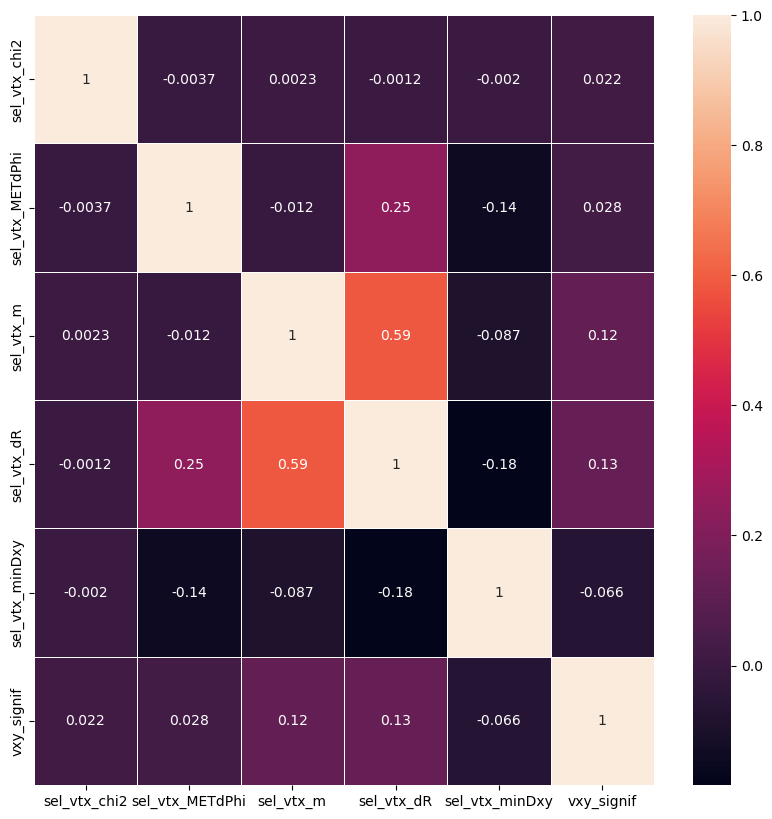

In [173]:
import seaborn as sb
from matplotlib.colors import LogNorm, Normalize

fig, ax = plt.subplots(figsize=(10,10))
ax = sb.heatmap(corr_all, annot=True, linewidths=.5)

Text(0.5, 1.0, 'PCC in Background Samples (Dataset size: 44146)')

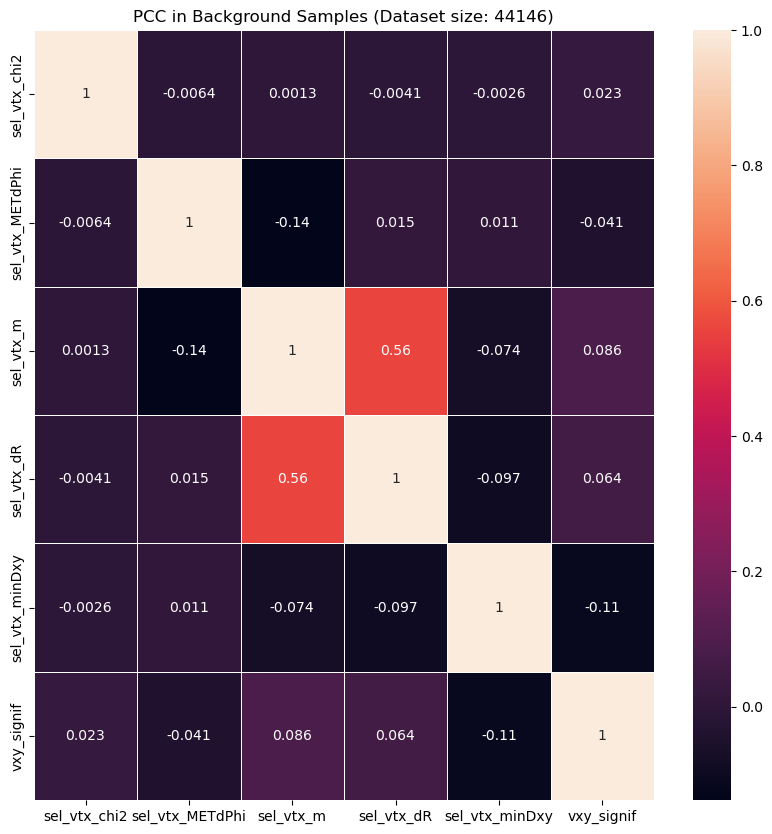

In [174]:
fig, ax = plt.subplots(figsize=(10,10))
ax = sb.heatmap(corr_bkg, annot=True, linewidths=.5)
plt.title(f'PCC in Background Samples (Dataset size: {bkg_data.shape[0]})') # Unweighted by xsec

Text(0.5, 1.0, 'PCC in Signal Samples (Dataset size: 6564)')

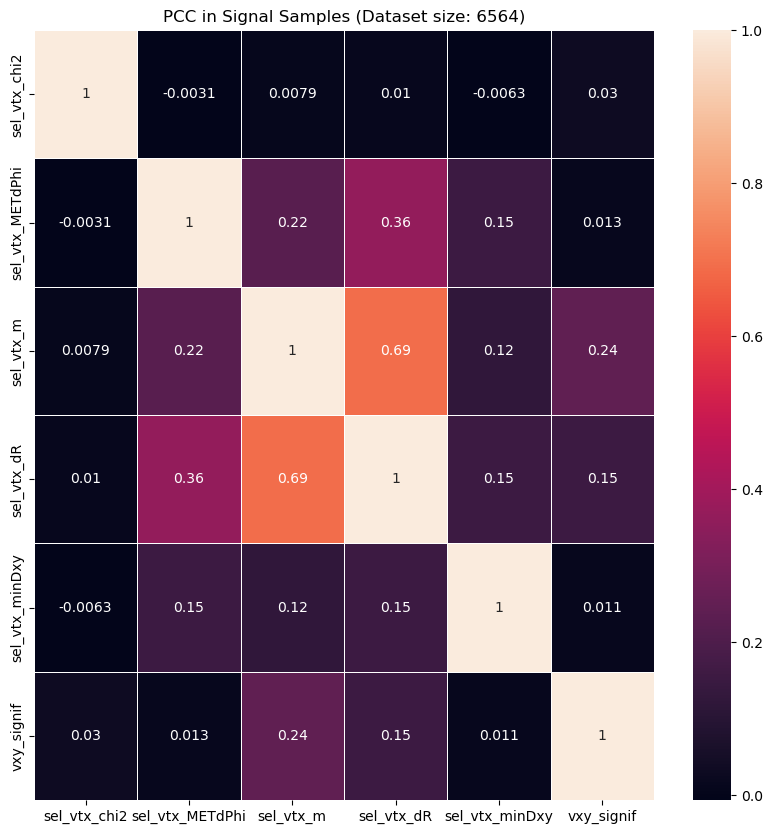

In [175]:
fig, ax = plt.subplots(figsize=(10,10))
ax = sb.heatmap(corr_sig, annot=True, linewidths=.5)
plt.title(f'PCC in Signal Samples (Dataset size: {sig_data.shape[0]})')